# A genome-wide atlas of recurrent repeat expansions in human cancer

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns

from scipy import stats

import statsmodels.api as sm
import statsmodels

from pyliftover import LiftOver

from pathlib import Path

%matplotlib inline
sns.set_context('paper', font_scale=1.1)
sns.set_style('ticks')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Data preparation

In [2]:
ROOT = Path('/labs/mpsnyder/gerwin/TR_analysis/')
CANCER_EXP_PATH = ROOT/'ashwini/V1.0/expt/cancer_v100/'
CANCER_LIST_PATH =ROOT/'ashwini/V1.0/src/cancerlist.v100'

In [3]:
CANCER_NAMES = [name.strip() for name in open("data/input/cancerlist.txt").readlines()]
CHROMS = [f"chr{i}" for i in range(1, 22+1)] + ['chrX', 'chrY']
RRE = pd.read_table("data/input/rre.tsv")
RRE["chr"] = "chr" + RRE["chr"]

In [4]:
REF_GENOME = "" # LEFT HERE
BAM_CAKI_1 = "/home/rashid/TR_analysis/rashid/dna_meth_rre/pbmm2/Caki-1.5mc.aligned.GRCh37.bam"
BAM_786_O = "/home/rashid/TR_analysis/rashid/dna_meth_rre/pbmm2/786-O.5mc.aligned.GRCh37.bam"

In [5]:
def calc_effect_size(control, experiment):
    # https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/cohens-d/
    pooled_sd = ((experiment.std() ** 2 + control.std() ** 2) / 2) ** 0.5
    mean_diff =  experiment.mean() - control.mean()
    return mean_diff / pooled_sd

## Main Figures

### (1A) Read depth before and after local read depth normalization

### (2E) Distance of rREs to the nearest cCRE

#### Download catalogs and sort

The simple repeats catalogue was downloaded from [the UCSC genome broswer](https://genome.ucsc.edu/cgi-bin/hgTables). The cCRE catalog (Registry V3 in hg38 coordinates) was downloaded from the [ENCODE project](https://screen.encodeproject.org/). Then, it was lifted over to hg19 using the online [liftover tool](https://genome.ucsc.edu/cgi-bin/hgLiftOver).

#### Clean and adjust size of simple repeats

In [6]:
simplerepeats = pd.read_table("data/input/simplerepeats.bed", header=None, usecols=range(3))
simplerepeats.columns = ["chr", "start", "stop"]

# only include repeats within chr1 to chrY
simplerepeats = simplerepeats.loc[simplerepeats["chr"].isin(CHROMS)]

Extend the lengths of simple repeats to the median of rREs. 

In [7]:
med_len = int((RRE["stop"] - RRE["start"]).median())
med_len

1645

In [8]:
# mid_point = (simplerepeats["stop"] + simplerepeats["start"]) // 2

# simplerepeats["start"] = mid_point - (med_len // 2)

# # cap start coordinates at 0
# simplerepeats.loc[simplerepeats["start"] < 0, "start"] = 0

# simplerepeats["stop"] = mid_point + (med_len // 2) + 1 # add one here because median length is odd

# # Confirm
# (simplerepeats["stop"] - simplerepeats["start"]).describe()

Save as BED file and sort.

In [9]:
simplerepeats.to_csv("data/input/simplerepeats_clean.bed", index=False, header=None, sep="\t")
!sort -k1,1 -k2,2n data/input/simplerepeats_clean.bed > data/input/simplerepeats_clean.sorted.bed

#### Find distance of closest cCRE to rREs and Simple Repeats

In [10]:
!module load bedtools && bedtools closest -d -t first -a "data/input/rre.bed" -b "data/input/ccre.sorted.bed" > "data/output/closest_rre_ccre.bed"

In [11]:
!module load bedtools && bedtools closest -d -t first -a "data/input/simplerepeats_clean.sorted.bed" -b "data/input/ccre.sorted.bed" > "data/output/closest_simplerepeats_ccre.bed"

#### Prepare data

In [12]:
rre_distance = pd.read_table("data/output/closest_rre_ccre.bed", header=None)
simple_distance = pd.read_table("data/output/closest_simplerepeats_ccre.bed", header=None)

# Extract distance column from bedtools output
distance_col = 9
rre_distance = rre_distance[[distance_col]].rename({distance_col: "distance"}, axis="columns")
simple_distance = simple_distance[[distance_col]].rename({distance_col: "distance"}, axis="columns")

rre_distance["type"] = "rREs"
simple_distance["type"] = "Simple Repeats"

# Convert distance to kbp
rre_distance["distance"] = rre_distance["distance"] / 10**3
simple_distance["distance"] = simple_distance["distance"] / 10**3

simple_distance = simple_distance[simple_distance["distance"] < 25000]

# Merge the two dataframes
data = pd.concat([rre_distance, simple_distance], ignore_index=True)

In [13]:
len(simplerepeats)

950265

In [14]:
len(simple_distance)

950091

In [15]:
len(simplerepeats) - len(simple_distance)

174

In [13]:
rre_distance.describe()

,distance
count,160.000000
mean,3.320762
std,7.576276
min,0.000000
25%,0.000000
50%,0.602000
75%,3.321250
max,67.925000


In [14]:
simple_distance.describe()

,distance
count,950091.000000
mean,10.311982
std,71.943080
min,0.000000
25%,0.378000
50%,1.450000
75%,4.167000
max,1785.032000


#### How many rREs directly overlap with a cCRE?

In [15]:
len(rre_distance[rre_distance["distance"] == 0])

54

#### Calculate p-value

In [16]:
_, p_value = stats.ttest_ind(rre_distance["distance"], simple_distance["distance"], equal_var=False)
print(f"p={p_value}")

p=4.736352146205243e-23


#### Calculate effect size (Cohens's d)

In [17]:
cohen_d = calc_effect_size(simple_distance["distance"], rre_distance["distance"])
print(f"d={cohen_d}")

d=-0.13667340743675332


#### Plot

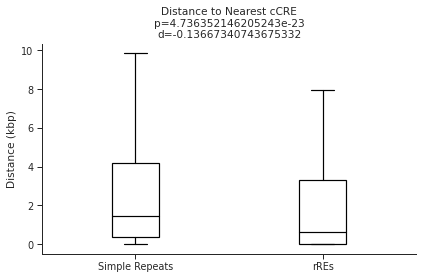

In [21]:
pdf = PdfPages("data/plot/2022-10-17-distance-to-nearest-ccre.pdf")

fig, ax = plt.subplots()
sns.boxplot(x="type", y="distance", order=["Simple Repeats", "rREs"], showfliers=False, width=0.25, data=data, ax=ax)
ax.set_title(f"Distance to Nearest cCRE\np={p_value}\nd={cohen_d}")
ax.set_xlabel("")
ax.set_ylabel("Distance (kbp)")

# ax.axhline(y=rre_distance["distance"].mean(), linestyle="-")
# ax.axhline(y=simple_distance["distance"].mean(), linestyle="--")

sns.despine()
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
ax.grid(False)
plt.tight_layout()

pdf.savefig(transparent=True)
pdf.close()

### (3C) Distance to prostate cancer risk loci

The Prost-AdenoCA risk loci were obtained from [Schumacker et al.](https://www.nature.com/articles/s41588-018-0142-8). We extract the first three columns (chr, start, stop) from the file and sort it. Then, we extract the chromosomes the the risk loci are located in.

In [8]:
!cat data/input/Prostate-AdenoCA-risk-loci-Schumaker-et-al.bed | awk '{print $1 "\t" $2 "\t" $3}' | sort -k1,1 -k2,2n > data/input/prost_risk_loci_clean.bed

#### Extract prostate and non-prostate rREs into BED files

In [9]:
prost_rre = RRE.loc[RRE["cancer"] == "Prost-AdenoCA"].copy()
non_prost_rre = RRE.loc[~(RRE["cancer"] == "Prost-AdenoCA")].copy()

len(prost_rre), len(non_prost_rre)

(105, 55)

In [10]:
prost_rre[["chr", "start", "stop"]].to_csv("data/input/prost_rre.bed", index=False, header=None, sep="\t")
!sort -k1,1 -k2,2n data/input/prost_rre.bed > data/input/prost_rre.sorted.bed

In [11]:
non_prost_rre[["chr", "start", "stop"]].to_csv("data/input/non_prost_rre.bed", index=False, header=None, sep="\t")
!sort -k1,1 -k2,2n data/input/non_prost_rre.bed > data/input/non_prost_rre.sorted.bed

#### Find distance

In [24]:
!module load bedtools && bedtools closest -d -a "data/input/prost_rre.sorted.bed" -b "data/input/prost_risk_loci_clean.bed" > "data/output/closest_prost_rre_risk_loci.bed"

In [25]:
!module load bedtools && bedtools closest -d -a "data/input/non_prost_rre.sorted.bed" -b "data/input/prost_risk_loci_clean.bed" > "data/output/closest_non_prost_rre_risk_loci.bed"

In [26]:
!module load bedtools && bedtools closest -d -a "data/input/simplerepeats_clean.sorted.bed" -b "data/input/prost_risk_loci_clean.bed" > "data/output/closest_simplerepeats_prost_risk_loci.bed"

#### Prepare data

In [27]:
prost_rre_distance = pd.read_table("data/output/closest_prost_rre_risk_loci.bed", header=None)
non_prost_rre_distance = pd.read_table("data/output/closest_non_prost_rre_risk_loci.bed", header=None)
simplerepeats_distance = pd.read_table("data/output/closest_simplerepeats_prost_risk_loci.bed", header=None)

In [28]:
# Extract distance column from bedtools output
distance_col = 6
prost_rre_distance = prost_rre_distance[[distance_col]].rename({distance_col: "distance"}, axis="columns")
non_prost_rre_distance = non_prost_rre_distance[[distance_col]].rename({distance_col: "distance"}, axis="columns")
simplerepeats_distance = simplerepeats_distance[[distance_col]].rename({distance_col: "distance"}, axis="columns")

prost_rre_distance["type"] = "Prost-AdenoCA rREs"
non_prost_rre_distance["type"] = "Non-Prost-AdenoCA rREs"
simplerepeats_distance["type"] = "Simple Repeats"

# Convert distance to kbp
prost_rre_distance["distance"] = prost_rre_distance["distance"] / 10**3
non_prost_rre_distance["distance"] = non_prost_rre_distance["distance"] / 10**3
simplerepeats_distance["distance"] = simplerepeats_distance["distance"] / 10**3

# Loci that exist on chroms that don't have a risk loci get assigned the max distance
prost_rre_distance.loc[prost_rre_distance["distance"] < 0, "distance"] = prost_rre_distance["distance"].max()
non_prost_rre_distance.loc[non_prost_rre_distance["distance"] < 0, "distance"] = non_prost_rre_distance["distance"].max()
simplerepeats_distance.loc[simplerepeats_distance["distance"] < 0, "distance"] = simplerepeats_distance["distance"].max()

# Merge the two dataframes
data = pd.concat([prost_rre_distance, non_prost_rre_distance, simplerepeats_distance], ignore_index=True)

len(prost_rre_distance), len(non_prost_rre_distance), len(simplerepeats_distance)

(105, 55, 950265)

#### Find p-value and effect size

In [29]:
_, p_value_prost_rre = stats.ttest_ind(prost_rre_distance["distance"], simplerepeats_distance["distance"], equal_var=False)
_, p_value_non_prost_rre = stats.ttest_ind(non_prost_rre_distance["distance"], simplerepeats_distance["distance"], equal_var=False)
print(f"Prost-AdenoCA rREs p={p_value_prost_rre}")
print(f"Non-Prost-AdenoCA rREs p={p_value_non_prost_rre}")

Prost-AdenoCA rREs p=0.07979367651795272
Non-Prost-AdenoCA rREs p=0.044088883877150695


In [30]:
_, q_values, _, _ = statsmodels.stats.multitest.multipletests([p_value_prost_rre, p_value_non_prost_rre], method='fdr_bh')
q_value_prost_rre, q_value_non_prost_rre = q_values[0], q_values[1]
print(f"Prost-AdenoCA rREs q={q_value_prost_rre}")
print(f"Non-Prost-AdenoCA rREs q={q_value_non_prost_rre}")

Prost-AdenoCA rREs q=0.07979367651795272
Non-Prost-AdenoCA rREs q=0.07979367651795272


In [31]:
cohen_d_prost_rre = calc_effect_size(simplerepeats_distance["distance"], prost_rre_distance["distance"])
cohen_d_non_prost_rre = calc_effect_size(simplerepeats_distance["distance"], non_prost_rre_distance["distance"])

print(f"Prost-AdenoCA rREs d={cohen_d_prost_rre}")
print(f"Non-Prost-AdenoCA rREs d={cohen_d_non_prost_rre}")

Prost-AdenoCA rREs d=-0.16827316124359148
Non-Prost-AdenoCA rREs d=0.28157559801942406


#### Plot

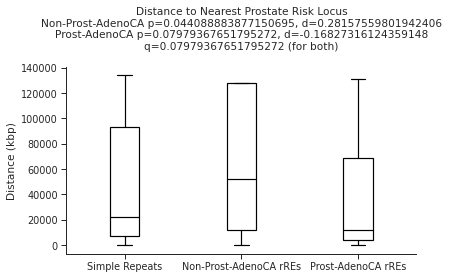

In [35]:
pdf = PdfPages("data/plot/2022-10-17-distance-to-prost-risk-loci.pdf")

fig, ax = plt.subplots()
sns.boxplot(x="type", y="distance", order=["Simple Repeats", "Non-Prost-AdenoCA rREs", "Prost-AdenoCA rREs"], showfliers=False, width=0.25, data=data, ax=ax)
ax.set_title(f"Distance to Nearest Prostate Risk Locus\nNon-Prost-AdenoCA p={p_value_non_prost_rre}, d={cohen_d_non_prost_rre}\nProst-AdenoCA p={p_value_prost_rre}, d={cohen_d_prost_rre}\nq={q_value_prost_rre} (for both)\n")
ax.set_xlabel("")
ax.set_ylabel("Distance (kbp)")

sns.despine()
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
ax.grid(False)
plt.tight_layout()

pdf.savefig(transparent=True)
pdf.close()

### (4B) Long-read DNA sequencing visualization

#### Create BED file for TRGT

In [75]:
df = pd.read_json("data/input/2022-Zhu-148-rRE-Annotations.json")

df[['chr', 'pos']] = df['ReferenceRegion'].str.split(":", expand=True)

df[['start', 'stop']] = df['pos'].str.split("-", expand=True)

df['struc'] = df['LocusStructure'].replace("\*", "n", regex=True) 

df['info'] = "ID=" + df["LocusId"] + ",STRUC=" + df['struc'] 

df['chr'] = df['chr'].replace("chr", "", regex=True)

trgt_bed = df[['chr', 'start', 'stop', 'info']]
trgt_bed.to_csv("data/input/rres_trtg.bed", sep="\t", header=None, index=False)

#### Download binaries

In [ ]:
!wget -O util/trvz.gz https://github.com/PacificBiosciences/trgt/releases/download/v0.3.2/trvz-v0.3.2-linux_x86_64.gz

In [ ]:
!wget -O util/trgt.gz https://github.com/PacificBiosciences/trgt/releases/download/v0.3.2/trgt-v0.3.2-linux_x86_64.gz

In [ ]:
!gunzip util/trvz.gz && gunzip util/trgt.gz

In [89]:
!chmod +x util/trgt util/trvz

#### Run TRGT

In [ ]:
!./trgt --genome example/reference.fasta --repeats example/repeat.bed \
       --reads example/sample.bam \
       --output-prefix sample

### (4D) UGT2B7 Transcript Isoform Differential Expression

#### Download transcript counts from PCAWG

In [ ]:
!wget -O data/input/pcawg.rnaseq.transcript.expr.counts.tsv.gz https://dcc.icgc.org/api/v1/download?fn=/PCAWG/transcriptome/transcript_expression/pcawg.rnaseq.transcript.expr.tpm.tsv.gz

In [53]:
!gunzip data/input/pcawg.rnaseq.transcript.expr.counts.tsv.gz

#### Prepare metadata for DESeq

In [16]:
transcripts = ['ENST00000305231.7', 'ENST00000508661.1', 'ENST00000502942.1']

patient_file_path = CANCER_EXP_PATH/'{}/output/patientdata/{}_paired_{}_{}_{}_{}.txt'.format('Kidney-RCC', 'Kidney-RCC', 'AAAG', 4, 69929297, 69930148)
patients = pd.read_csv(patient_file_path, sep='\t')
patients = patients.rename(columns={'case_id': 'icgc_donor_id'})

metadata = pd.read_csv('data/input/rnaseq.extended.metadata.aliquot_id.V4.tsv', sep='\t')
metadata = metadata.rename(columns={'tumor.normal': 'sample_type'})    
metadata = metadata[metadata['sample_type'] == 'tumor']
metadata = metadata.merge(patients, on='icgc_donor_id')
metadata = metadata.rename({'aliquot_id': 'id'}, axis='columns')
metadata = metadata[["id", "exp"]]

metadata.to_csv("data/input/ugt2b7_expr_metadata.csv", index=False)

len(metadata)

49

In [17]:
metadata

,id,exp
0,ca74074b-a75c-434c-82dc-e7b112d192ef,No
1,910c8543-cc94-4499-82fe-365c24eac5b1,Yes
2,22f1d19e-14f8-403e-9e48-663da7508bf2,No
3,f59f0b5c-a5ac-4859-a862-3425c623341d,No
4,fd0df2dd-fa09-4ec1-8996-c6c6aca9c2a6,Yes
5,f4cc72cf-6f47-4ebc-a9ab-9ba15b6fa411,Yes
6,91953b3b-e9ea-49be-a403-92d7a97e4ebc,No
7,d69871fb-9d93-4a3f-b4ea-f53de743b25f,Yes
8,50db517a-a5c7-431e-9439-cb5cffb9b954,Yes
9,75525e48-2c6d-4b74-b22b-3d2dcd7fde74,Yes


#### Run DESeq

In [ ]:
Run the 

In [19]:
tpm = pd.read_table("data/input/pcawg.rnaseq.transcript.expr.tpm.tsv")
tpm.head()

,Transcript,b337121c-9821-4644-820e-b8c477f6c38a,612ef912-5a28-4c11-8703-3376f51afef5,56a705f4-fd28-44ff-8a3c-85bc4300c760,28239a0e-9990-49ef-a159-ba63fb078c77,fbf2f1c0-fb91-4548-8653-68021e6541f9,01b7a29e-0d3a-4a18-8cb6-f8a329f9d6e6,4aa70762-1a0e-4b38-be77-a89db0955193,2de8f5dd-decd-47f4-856a-bda678ee6ab8,d8164b02-4b3c-454d-945b-2838edb1b5b1,...,df0df04e-bb65-4dd6-91db-753eaa86a0c3,ccdfd8a3-2bc7-474c-b80d-96e8741fe8bc,06dbb69c-390b-4174-859b-c1e20380b483,6a3488f6-b364-426c-bb80-77acc0da4ff8,52739598-8083-45b3-b89e-4d841cb15d7a,e80aa591-ed43-4486-a7cd-0ea654f10983,27b37399-0a77-400e-9dff-0c9c26455144,6d98d09b-cdec-4f71-afb3-2c53bee990c4,9734c685-9f30-4c0b-b9ba-06bec4b3ca64,88E25F76-1B1F-4AFB-AB08-215D4F7F08B5
0,ENST00000335137.3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,ENST00000423372.3,44.60,69.58,35.31,24.14,12.10,84.50,68.78,19.09,12.46,...,66.76,97.87,76.92,159.50,106.01,69.07,54.83,141.96,86.25,37.78
2,ENST00000426406.1,0.06,0.05,0.02,0.02,0.01,0.03,0.08,0.02,0.04,...,0.03,0.20,0.02,0.02,0.00,0.05,0.01,0.00,0.00,0.01
3,ENST00000332831.2,0.06,0.05,0.02,0.02,0.01,0.03,0.08,0.02,0.04,...,0.03,0.20,0.02,0.02,0.00,0.05,0.01,0.00,0.00,0.01
4,ENST00000599533.1,1.60,1.86,1.48,0.00,1.02,1.84,0.94,1.25,1.05,...,0.31,2.91,3.45,0.63,7.81,4.76,1.96,3.93,0.92,5.05


In [50]:
transcript_dfs = []
for t in transcripts:
    df = tpm.loc[tpm['Transcript'].str.startswith(t)]
    print(df.iloc[0]["Transcript"])
    df = df.transpose().reset_index()
    df = df.drop(0, axis='rows')
    df.columns = ['aliquot_id', 'tpm']
    df['transcript'] = t
    transcript_dfs.append(df)
    
data = pd.concat(transcript_dfs, ignore_index=True)
data = data.merge(samples, on=['aliquot_id'], suffixes=('',''))
data.head()

ENST00000305231.7
ENST00000508661.1
ENST00000502942.1


,aliquot_id,tpm,transcript,exp
0,ca74074b-a75c-434c-82dc-e7b112d192ef,72.68,ENST00000305231,No
1,ca74074b-a75c-434c-82dc-e7b112d192ef,1.94,ENST00000508661,No
2,ca74074b-a75c-434c-82dc-e7b112d192ef,332.22,ENST00000502942,No
3,910c8543-cc94-4499-82fe-365c24eac5b1,60.27,ENST00000305231,Yes
4,910c8543-cc94-4499-82fe-365c24eac5b1,0.73,ENST00000508661,Yes


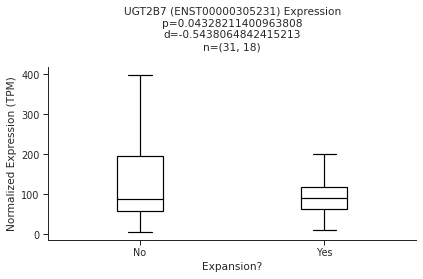

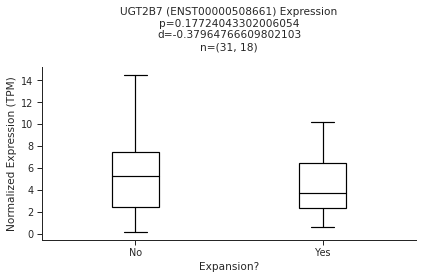

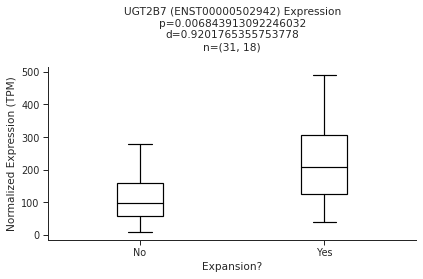

In [51]:
for t in transcripts:
    pdf = PdfPages(f"data/plot/2022-10-06-ugt2b7-expr-{t}.pdf")
    
    t_data = data[data["transcript"] == t]
    
    assert(len(t_data) == t_data["aliquot_id"].nunique())
    
    t_data_no = t_data[t_data["exp"] == "No"]
    t_data_yes = t_data[t_data["exp"] == "Yes"]
    n_no, n_yes = len(t_data_no), len(t_data_yes)

    _, p_value = stats.ttest_ind(t_data_no["tpm"], t_data_yes["tpm"], equal_var=False)
    cohen_d = calc_effect_size(t_data_no["tpm"], t_data_yes["tpm"])

    fig, ax = plt.subplots()
    df = data[data["transcript"] == t]
    sns.boxplot(x="exp", y="tpm", showfliers=False, width=0.25, data=t_data, ax=ax)
    ax.set_title(f"UGT2B7 ({t}) Expression\np={p_value}\nd={cohen_d}\nn=({n_no}, {n_yes})\n")
    ax.set_xlabel("Expansion?")
    ax.set_ylabel("Normalized Expression (TPM)")

    sns.despine()
    plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    plt.setp(ax.lines, color='k')
    ax.grid(False)
    plt.tight_layout()

    pdf.savefig(transparent=True)
    pdf.close()

## Extended Data Figures

### (2D) Estimated Frequency of rREs in the population

Here, I am first making a table of the average global-normalized anchored IRR value for each rRE. Then, I am joining that table with the table from Ryan Yuen which has the anchored IRR value for each rRE for each sample in the 1000 Genomes dataste plus others.

The bigger picture here is to find loci that are generally shorter than the read length in the population by looking at the average global-normalized anchored IRR value, and then calling samples in the 1000Genomes dataset with an IRR count higher than a threshold expanded (meaning that they are longer than the read length in that sample).

#### Settings

In [123]:
PERCENTILE = 99

#### Make a table of avg Anchored IRR value for PCAWG

In [169]:
tropic = pd.read_table('data/input/tropic_rre.tsv')
lrdn = pd.read_table('data/input/rre.tsv')
len(tropic), len(lrdn)

(578, 160)

In [170]:
merged = lrdn.merge(tropic, on=['chr', 'start', 'stop', 'motif', 'cancer'], suffixes=('_lrdn', '_tropic'))
merged

,chr,start,stop,motif,p-value_lrdn,corrected_p-value_lrdn,raw_data_lrdn,keep_lrdn,q-value_lrdn,paired_count_lrdn,...,lrdn_q-value,med_case_gt_control,p-value_tropic,corrected_p-value_tropic,raw_data_tropic,keep_tropic,q-value_tropic,paired_count_tropic,expansion_count_tropic,expansion_percent_tropic
0,1,2052209,2053620,AACCACCACCGTGACCCT,4.658371e-03,1.000000,case_01438f392ca16551d81218111181b9dd.bam:2.88...,Yes,0.059470,198,...,5.869867e-05,True,4.658371e-03,1.000000,case_01438f392ca16551d81218111181b9dd.bam:2.10...,Yes,0.059470,198,14,7.070707
1,1,4195391,4197375,AACCCACTCCCATGATAACT,1.065526e-02,1.000000,case_0095dee3b343c04564a762b9ff2dd316.bam:12.6...,Yes,0.095536,198,...,1.506804e-06,True,1.065526e-02,1.000000,case_0095dee3b343c04564a762b9ff2dd316.bam:15.1...,Yes,0.095536,198,13,6.565657
2,1,5855301,5856988,ACCACCAGGGCTCAGTC,8.044067e-06,0.078044,case_0095dee3b343c04564a762b9ff2dd316.bam:5.72...,Yes,0.001362,198,...,1.462786e-09,True,8.044067e-06,0.078044,case_0095dee3b343c04564a762b9ff2dd316.bam:6.73...,Yes,0.001362,198,22,11.111111
3,1,19251719,19252987,ATCC,5.786908e-06,0.056145,case_0095dee3b343c04564a762b9ff2dd316.bam:1.70...,Yes,0.001099,198,...,6.671162e-05,True,5.786908e-06,0.056145,case_0095dee3b343c04564a762b9ff2dd316.bam:2.80...,Yes,0.001099,198,20,10.101010
4,1,41996161,41998397,ACAGGAGAGATGGAGG,3.769546e-07,0.003657,case_0095dee3b343c04564a762b9ff2dd316.bam:3.48...,Yes,0.000199,198,...,2.454188e-08,True,3.769546e-07,0.003657,case_0095dee3b343c04564a762b9ff2dd316.bam:3.92...,Yes,0.000199,198,25,12.626263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,X,68032465,68033958,AAAAATATATAT,3.261746e-05,1.000000,case_001642979e361dc2c60f0128740b258b.bam:2.17...,Yes,0.032403,314,...,8.582909e-08,True,3.261746e-05,1.000000,case_001642979e361dc2c60f0128740b258b.bam:0.74...,Yes,0.032403,314,34,10.828025
156,X,125168784,125170222,AAATATATATACATATAT,1.043650e-04,1.000000,case_001642979e361dc2c60f0128740b258b.bam:2.18...,Yes,0.081462,314,...,1.693245e-07,True,1.043650e-04,1.000000,case_001642979e361dc2c60f0128740b258b.bam:0.74...,Yes,0.081462,314,23,7.324841
157,X,127660583,127661711,AATATAGACTATATTATAT,8.555494e-09,0.000661,case_001642979e361dc2c60f0128740b258b.bam:4.47...,Yes,0.000069,314,...,4.072629e-11,True,8.555494e-09,0.000661,case_001642979e361dc2c60f0128740b258b.bam:1.49...,Yes,0.000069,314,64,20.382166
158,X,127660813,127661371,AATATAGACTATATTATAT,4.638831e-07,0.003212,case_053b909dcf2c4d1a4aba94a7f4fd0299.bam:14.5...,Yes,0.001343,89,...,1.809622e-05,True,4.638831e-07,0.003212,case_053b909dcf2c4d1a4aba94a7f4fd0299.bam:7.01...,Yes,0.001343,89,29,32.584270


#### Calculate the average IRR value for control samples for each locus

In [171]:
def get_control_irr_val_cutoff(repeat):
    # Initialize all IRR values of files to zero (only for control samples)
    cancer = repeat['cancer']
    manifest_path = f'data/input/EHdn_v097_Manifests/{cancer}.manifest.tsv'
    manifest = pd.read_csv(manifest_path, header=None, sep=' ')
    file_names = list(manifest[0])
    irr_values = {f_name: 0 for f_name in file_names if f_name.startswith('control_')}

    # Assign IRR values based on ExpansionHunter output
    entries = repeat['raw_data_tropic'].split(',')
    for entry in entries:
        f_name, irr_value = entry.split(':')
        if f_name.startswith('control_'):
            irr_values[f_name] = float(irr_value)

    # avg = np.mean(list(irr_values.values()))
    cutoff = np.percentile(list(irr_values.values()), PERCENTILE)
    
    return cutoff

merged['control_irr_cutoff'] = merged.apply(get_control_avg_irr_val, axis=1)

In [172]:
rre = merged[['chr', 'start', 'stop', 'motif', 'cancer', 'control_irr_cutoff']].copy()

In [173]:
rre['chr'] = 'chr' + rre['chr'].astype(str)
len(filtered_loci)

160

#### Add some columns we'll use later

In [174]:
rre['locus_id'] = rre['chr'] + '_' + rre['start'].astype(str) + '_' + rre['stop'].astype(str)
rre['locus_chr'] = rre['chr']

# Expand the window by +/- 1kbp because this is how Yuen did it and we
# need to match our Locus IDs with his Cancer IDS
rre['locus_start'] = rre['start'].astype(int) - 1000
rre['locus_stop'] = rre['stop'].astype(int) + 1000

rre.head()

,chr,start,stop,motif,cancer,control_irr_cutoff,locus_id,locus_chr,locus_start,locus_stop
0,chr1,2052209,2053620,AACCACCACCGTGACCCT,Prost-AdenoCA,5.494420,chr1_2052209_2053620,chr1,2051209,2054620
1,chr1,4195391,4197375,AACCCACTCCCATGATAACT,Prost-AdenoCA,31.668194,chr1_4195391_4197375,chr1,4194391,4198375
2,chr1,5855301,5856988,ACCACCAGGGCTCAGTC,Prost-AdenoCA,2.649755,chr1_5855301_5856988,chr1,5854301,5857988
3,chr1,19251719,19252987,ATCC,Prost-AdenoCA,5.986935,chr1_19251719_19252987,chr1,19250719,19253987
4,chr1,41996161,41998397,ACAGGAGAGATGGAGG,Prost-AdenoCA,7.400395,chr1_41996161_41998397,chr1,41995161,41999397


#### Load the 1000Genomes IRR table

In [175]:
irr = pd.read_table('data/input/rREs-v1.0.0.hg38.padded.EHdn_overlap.tsv')

#### Split the Cancer_ID & EHdn_ID columns

In [176]:
irr[['cancer_chr', 'cancer_start', 'cancer_stop', 'cancer_motif', 'cancer_type']] = irr['Cancer_ID'].str.split(':', n=4, expand=True)

In [177]:
irr[['ehdn_chr', 'ehdn_start', 'ehdn_stop', 'ehdn_motif']] = irr['EHdn_ID'].str.split(':', n=3, expand=True)

#### Conver to numeric types

In [178]:
irr[['ehdn_start', 'ehdn_stop']] = irr[['ehdn_start', 'ehdn_stop']].apply(pd.to_numeric)

In [179]:
irr[['cancer_start', 'cancer_stop']] = irr[['cancer_start', 'cancer_stop']].apply(pd.to_numeric)

#### Liftover

In [180]:
lo = LiftOver('hg19', 'hg38')

In [181]:
rre[['locus_start_hg38', 'locus_stop_hg38']] = -1
        
for i, row in rre.iterrows():
    chr, start, stop = row['locus_chr'], row['locus_start'], row['locus_stop']
    possible_start = lo.convert_coordinate(chr, start)
    possible_stop = lo.convert_coordinate(chr, stop)
    if possible_start and possible_stop:
        # make sure liftover chr matches original
        assert(possible_start[0][0] == chr and possible_stop[0][0] == chr) 
        rre.loc[i, 'locus_start_hg38'] = possible_start[0][1]
        rre.loc[i, 'locus_stop_hg38'] = possible_stop[0][1]

#### Merge IRR table with table that matched Cancer_ID in Yuen's file with our locus IDs

In [182]:
merged = irr.merge(rre, right_on=['locus_chr', 'locus_start_hg38', 'locus_stop_hg38'], left_on=['cancer_chr', 'cancer_start', 'cancer_stop'])

#### Convert IRR values to 100bp

In [183]:
sample_cols = merged.columns[3:-21]
merged[sample_cols] = 0.5 + 1.5 * merged[sample_cols]

In [185]:
merged.head()

,Cancer_ID,EHdn_ID,Motif_match,AAAAA,AAAAB,AAAAC,AAAAD,AAAAE,AAAAF,AAAAG,...,stop,motif,cancer,control_irr_cutoff,locus_id,locus_chr,locus_start,locus_stop,locus_start_hg38,locus_stop_hg38
0,chr1:2119770:2123181:AACCACCACCGTGACCCT:Prost-...,chr1:2121347:2121553:AACAACCGCCGCGACCCT,False,0.5,0.5,0.5,0.50,0.5,0.50,0.5,...,2053620,AACCACCACCGTGACCCT,Prost-AdenoCA,5.49442,chr1_2052209_2053620,chr1,2051209,2054620,2119770,2123181
1,chr1:2119770:2123181:AACCACCACCGTGACCCT:Prost-...,chr1:2121392:2121540:AACAACCGCCGTGACCCT,False,0.5,0.5,0.5,0.50,0.5,0.50,0.5,...,2053620,AACCACCACCGTGACCCT,Prost-AdenoCA,5.49442,chr1_2052209_2053620,chr1,2051209,2054620,2119770,2123181
2,chr1:2119770:2123181:AACCACCACCGTGACCCT:Prost-...,chr1:2121292:2122083:AACCACCACCACGACCCT,False,0.5,0.5,0.5,0.50,0.5,0.50,0.5,...,2053620,AACCACCACCGTGACCCT,Prost-AdenoCA,5.49442,chr1_2052209_2053620,chr1,2051209,2054620,2119770,2123181
3,chr1:2119770:2123181:AACCACCACCGTGACCCT:Prost-...,chr1:2120906:2121887:AACCACCACCATCACCCT,False,0.5,0.5,0.5,1.76,0.5,0.50,0.5,...,2053620,AACCACCACCGTGACCCT,Prost-AdenoCA,5.49442,chr1_2052209_2053620,chr1,2051209,2054620,2119770,2123181
4,chr1:2119770:2123181:AACCACCACCGTGACCCT:Prost-...,chr1:2121046:2121978:AACCACCACCATGACCCT,False,0.5,0.5,0.5,0.50,0.5,1.85,0.5,...,2053620,AACCACCACCGTGACCCT,Prost-AdenoCA,5.49442,chr1_2052209_2053620,chr1,2051209,2054620,2119770,2123181


#### Replace IRR values with 0 for not expanded and 1 for expanded

In [186]:
sample_cols = merged.columns[3:-21]

for col in sample_cols:
    merged[col] = merged[col].astype(float) > merged['control_irr_cutoff']

#### Find number of expansions for each row (locus) and then percentage

We set the number of expansions to 0 if the motif does not match (because that indicates the rRE is not actually present)

In [187]:
merged['n_expanded'] = merged[sample_cols].sum(axis=1).where(merged['Motif_match'], 0)

In [188]:
merged['pct_expanded'] = merged['n_expanded'] / len(sample_cols)

In [189]:
merged.head()

,Cancer_ID,EHdn_ID,Motif_match,AAAAA,AAAAB,AAAAC,AAAAD,AAAAE,AAAAF,AAAAG,...,cancer,control_irr_cutoff,locus_id,locus_chr,locus_start,locus_stop,locus_start_hg38,locus_stop_hg38,n_expanded,pct_expanded
0,chr1:2119770:2123181:AACCACCACCGTGACCCT:Prost-...,chr1:2121347:2121553:AACAACCGCCGCGACCCT,False,False,False,False,False,False,False,False,...,Prost-AdenoCA,5.49442,chr1_2052209_2053620,chr1,2051209,2054620,2119770,2123181,0,0.0
1,chr1:2119770:2123181:AACCACCACCGTGACCCT:Prost-...,chr1:2121392:2121540:AACAACCGCCGTGACCCT,False,False,False,False,False,False,False,False,...,Prost-AdenoCA,5.49442,chr1_2052209_2053620,chr1,2051209,2054620,2119770,2123181,0,0.0
2,chr1:2119770:2123181:AACCACCACCGTGACCCT:Prost-...,chr1:2121292:2122083:AACCACCACCACGACCCT,False,False,False,False,False,False,False,False,...,Prost-AdenoCA,5.49442,chr1_2052209_2053620,chr1,2051209,2054620,2119770,2123181,0,0.0
3,chr1:2119770:2123181:AACCACCACCGTGACCCT:Prost-...,chr1:2120906:2121887:AACCACCACCATCACCCT,False,False,False,False,False,False,False,False,...,Prost-AdenoCA,5.49442,chr1_2052209_2053620,chr1,2051209,2054620,2119770,2123181,0,0.0
4,chr1:2119770:2123181:AACCACCACCGTGACCCT:Prost-...,chr1:2121046:2121978:AACCACCACCATGACCCT,False,False,False,False,False,False,False,False,...,Prost-AdenoCA,5.49442,chr1_2052209_2053620,chr1,2051209,2054620,2119770,2123181,0,0.0


In [191]:
result = merged[['locus_id', 'Cancer_ID', 'EHdn_ID', 'Motif_match', 'control_irr_cutoff', 'n_expanded', 'pct_expanded']]

#### For every locus_id, leave only one EHdn_ID (or row) and have it be the Motif_match=True if there is one

In [192]:
result = result.sort_values('Motif_match', ascending=False).drop_duplicates('locus_id').sort_values('pct_expanded', ascending=False).reset_index(drop=True)

#### Remove loci that do not have matching motif

In [193]:
result = result[result['Motif_match'] == True].reset_index(drop=True)

In [194]:
result.to_csv(f'data/output/2022-10-14-rre_1000g-irr-percentile-{PERCENTILE}.tsv', index=False, sep='\t')

In [195]:
result.head()

,locus_id,Cancer_ID,EHdn_ID,Motif_match,control_irr_cutoff,n_expanded,pct_expanded
0,chr2_95702030_95705646,chr2:95035285:95040901:ACTC:Prost-AdenoCA,chr2:95036079:95039925:ACTC,True,5.864893,5022,0.770955
1,chr19_51001474_51003542,chr19:50497217:50501285:AG:Prost-AdenoCA,chr19:50498119:50500511:AG,True,4.162295,4408,0.676696
2,chr12_127315830_127317099,chr12:126830284:126833553:AGG:Prost-AdenoCA,chr12:126831268:126833103:AGG,True,8.382161,3837,0.589039
3,chr17_77866940_77868482,chr17:79892141:79895683:ATC:Prost-AdenoCA,chr17:79893053:79894656:ATC,True,4.925018,3705,0.568775
4,chr17_78673700_78675010,chr17:80698900:80702210:ACC:Prost-AdenoCA,chr17:80699757:80701306:ACC,True,4.988921,3624,0.556340


In [196]:
result.sort_values('pct_expanded', ascending=False)

,locus_id,Cancer_ID,EHdn_ID,Motif_match,control_irr_cutoff,n_expanded,pct_expanded
0,chr2_95702030_95705646,chr2:95035285:95040901:ACTC:Prost-AdenoCA,chr2:95036079:95039925:ACTC,True,5.864893,5022,0.770955
1,chr19_51001474_51003542,chr19:50497217:50501285:AG:Prost-AdenoCA,chr19:50498119:50500511:AG,True,4.162295,4408,0.676696
2,chr12_127315830_127317099,chr12:126830284:126833553:AGG:Prost-AdenoCA,chr12:126831268:126833103:AGG,True,8.382161,3837,0.589039
3,chr17_77866940_77868482,chr17:79892141:79895683:ATC:Prost-AdenoCA,chr17:79893053:79894656:ATC,True,4.925018,3705,0.568775
4,chr17_78673700_78675010,chr17:80698900:80702210:ACC:Prost-AdenoCA,chr17:80699757:80701306:ACC,True,4.988921,3624,0.556340
...,...,...,...,...,...,...,...
111,chr7_156309532_156311311,chr7:156515838:156519617:ACACAGCCTCCCTC:Prost-...,chr7:156516956:156518300:ACACAGCCTCCCTC,True,6.544628,0,0.000000
112,chr8_57239613_57240997,chr8:56326054:56329438:AAATATATATAT:Liver-HCC,chr8:56327248:56328324:AAATATATATAT,True,16.885395,0,0.000000
113,chr8_73473300_73474607,chr8:72560065:72563372:AT:Liver-HCC,chr8:72561056:72562243:AT,True,8.925911,0,0.000000
114,chr7_121243013_121243813,chr7:121601959:121604759:AAAG:Lung-SCC,chr7:121602590:121603850:AAAG,True,5.236269,0,0.000000


In [197]:
result['pct_expanded'].describe()

count    143.000000
mean       0.062434
std        0.143839
min        0.000000
25%        0.000000
50%        0.001075
75%        0.032315
max        0.770955
Name: pct_expanded, dtype: float64

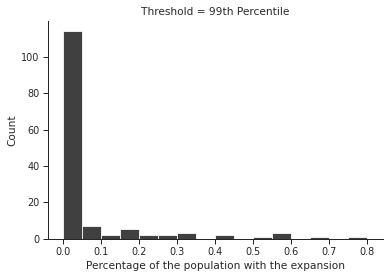

In [199]:
pdf = PdfPages(f'data/plot/2022-10-14-rre-expansion-1000g-percentile-{PERCENTILE}.pdf')
ax = sns.histplot(x='pct_expanded', data=result, binwidth=0.05, color='black')
ax.set_title(f'Threshold = {PERCENTILE}th Percentile')
ax.set_xlabel('Percentage of the population with the expansion')
ax.grid(False)
sns.despine(ax=ax, top=True, right=True)
pdf.savefig()
pdf.close()

### (3A) Example of read depth before and after LRDN (2 loci)


### (3B) Anchored IRR values boxplot expamples before and after LRDN

### (4A) LRDN Benchmark Global Norm IRR count

### (4B) LRDN Benchmark Local Norm IRR count

### (5C) Correlation of rREs with Mutational Signatures

### (5D) Correlation of rREs with Mutational Signatures Excluding Lung-SCC rRE

### (6B) Replication timing (USES SIMPLE REPEATS)

In [20]:
!module load bedtools && bedtools intersect -a data/input/replication_timing.bed -b data/input/rre.bed > data/output/rre_repl_time.bed

In [21]:
!module load bedtools && bedtools intersect -a data/input/replication_timing.bed -b data/input/simplerepeats_clean.sorted.bed > data/output/simplerepeats_repl_time.bed

In [23]:
re = pd.read_csv("data/output/rre_repl_time.bed", sep='\t', header=None, names=['chr', 'start', 'stop', 'timing'])
simple = pd.read_csv('data/output/simplerepeats_repl_time.bed', sep='\t', header=None, names=['chr', 'start', 'stop', 'timing'])

In [24]:
re['type'] = 'rREs'
simple['type'] = 'Simple Repeats'

In [25]:
raw_data_arr = [simple, re]
raw_data = pd.concat(raw_data_arr)

In [26]:
raw_data.head()

,chr,start,stop,timing,type
0,chr1,9412,11057,Late,Simple Repeats
1,chr1,9891,11536,Late,Simple Repeats
2,chr1,10055,11700,Late,Simple Repeats
3,chr1,10514,12159,Late,Simple Repeats
4,chr1,10537,12182,Late,Simple Repeats


In [27]:
raw_data = raw_data[raw_data['timing'] != 'Undetermined']

In [28]:
raw_data[raw_data['chr'] == 'chrX'].groupby(['type', 'timing']).size().reset_index(name='count')

,type,timing,count
0,Simple Repeats,Early,23533
1,Simple Repeats,Late,5693
2,rREs,Early,5


In [29]:
data = raw_data[['type', 'timing']].groupby(['type', 'timing']).size().reset_index(name='count')
data.head()

,type,timing,count
0,Simple Repeats,Early,257377
1,Simple Repeats,Late,289088
2,rREs,Early,45
3,rREs,Late,60


In [30]:
for t in list(data['type'].unique()):
    subset = data[data['type'] == t]
    total = subset['count'].sum()
    data.loc[data['type'] == t, 'pct'] = data['count'] / total

data['pct'] *= 100
data.head()

,type,timing,count,pct
0,Simple Repeats,Early,257377,47.098533
1,Simple Repeats,Late,289088,52.901467
2,rREs,Early,45,42.857143
3,rREs,Late,60,57.142857


In [31]:
early = data[data['timing'] == 'Early']
late = data[data['timing'] == 'Late']

first = early[['type', 'pct']].copy().reset_index()

second = late[['type', 'pct']].copy().reset_index()
second['pct'] += first['pct']

In [41]:
pdf = PdfPages('data/plot/2022-10-14-distribution_repl_time.pdf') 

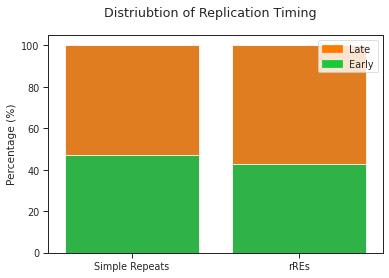

In [42]:
fig, ax = plt.subplots()

palette = sns.color_palette('bright')

colors = [palette[7], palette[1], palette[2], 'white']
# colors = ['grey', '#978fba', '#fffae0', 'black']

order = ['Simple Repeats', 'rREs']
#order = ['Repeat Expansions\n(Early={}, Late={})'.format(data.at[0, 'count'], data.at[1, 'count']), 'Simple Repeats\n(Early={}, Late={})'.format(data.at[2, 'count'], data.at[3, 'count'])]


# sns.barplot(x='type', y='pct', data=third, color=colors[0], edgecolor=colors[3], order=order, ax=ax)
sns.barplot(x='type', y='pct', data=second, color=colors[1], edgecolor=colors[3], order=order, ax=ax)
sns.barplot(x='type', y='pct', data=first, color=colors[2], edgecolor=colors[3], order=order, ax=ax)

#und_patch = matplotlib.patches.Patch(color=colors[0], label='Undetermined')
late_patch = matplotlib.patches.Patch(color=colors[1], label='Late')
early_patch = matplotlib.patches.Patch(color=colors[2], label='Early')

#ax.legend(handles=[und_patch, late_patch, early_patch], bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.legend(handles=[und_patch, late_patch, early_patch])
ax.legend(handles=[late_patch, early_patch])


fig.suptitle('Distriubtion of Replication Timing')
ax.set_xlabel('')
ax.set_ylabel('Percentage (%)')



pdf.savefig(transparent=True)

In [43]:
# Bootstrap p-value
np.random.seed(1)

N = 10000
n_sample_each_time = 35+19 # No. of repeat expansions that are either early or late

obs_early_count = data.loc[(data['type'] == 'rREs') & (data['timing'] == 'Early'), 'count'].iloc[0]
obs_late_count = data.loc[(data['type'] == 'rREs') & (data['timing'] == 'Late'), 'count'].iloc[0]

exp_early_count = data.loc[(data['type'] == 'Simple Repeats') & (data['timing'] == 'Early'), 'count'].iloc[0]
exp_late_count = data.loc[(data['type'] == 'Simple Repeats') & (data['timing'] == 'Late'), 'count'].iloc[0]

# Probability of observing "early region" for repeat expansions (observation) and simple repeats (expected)
p_observed = obs_early_count / (obs_early_count + obs_late_count)
p_expected = exp_early_count / (exp_early_count + exp_late_count)

chi_p_values = np.zeros(N)
chi_cumulative = np.zeros(N)

t_p_values = np.zeros(N)
t_cumulative = np.zeros(N)

for i in range(N):
    # Take 'n_sample_each_time' samples and record how many of them are "early regions" and how many are "late"
    n_early_obs = np.random.binomial(n_sample_each_time, p_observed)
    n_early_exp = np.random.binomial(n_sample_each_time, p_expected)
    n_late_obs = n_sample_each_time - n_early_obs
    n_late_exp = n_sample_each_time - n_early_exp
    
    # Calculate a chisqure p_value of observering these frequencies
    _, p_value = stats.chisquare([n_early_obs, n_late_obs], f_exp=[n_early_exp, n_late_exp])
    chi_p_values[i] = p_value
    chi_cumulative[i] = np.mean(chi_p_values[:i+1])
    
    # Calculate a ttest p-value
    obs_distribtion = np.zeros(n_sample_each_time)
    exp_distribtion = np.zeros(n_sample_each_time)
    
    obs_distribtion[:n_early_obs] = 1
    exp_distribtion[:n_early_exp] = 1
    
    _, p_value = stats.ttest_ind(obs_distribtion, exp_distribtion, equal_var=False)
    t_p_values[i] = p_value
    t_cumulative[i] = np.mean(t_p_values[:i+1])
    
    
t_cumulative[N-1], chi_cumulative[N-1]

(0.47102124233835446, 0.36268993485909234)

<AxesSubplot:>

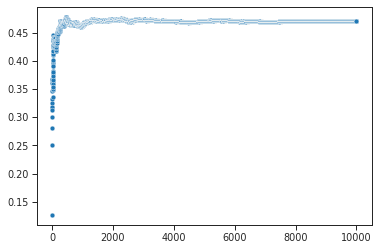

In [44]:
sns.scatterplot(x=np.arange(N), y=t_cumulative)

<AxesSubplot:>

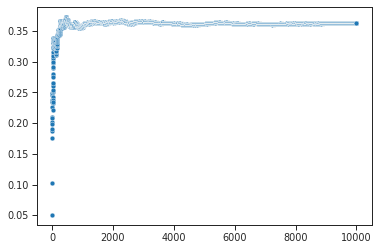

In [45]:
sns.scatterplot(x=np.arange(N), y=chi_cumulative)

In [46]:
# labels = []
# p_values = []
# for i in range(1, len(raw_data_arr)):
#     curr_type = raw_data_arr[i].iloc[0]['type']
#     labels.append('Repeat Expansions vs. {}'.format(curr_type))
#     observed = data[data['type'] == 'Repeat Expansions']['count']
#     expected = data[data['type'] == curr_type]['count']
    
#     # Scale observed frequencies to match expected
#     observed *= (expected.sum() // observed.sum())
    
#     _, p_value = stats.chisquare(observed, f_exp=expected)
#     p_values.append(p_value)
    
# #     print('p={} for observation freq. {} and {}'.format(p_value, list(observed), list(expected)))

# _, p_values_corr, _, _ = statsmodels.stats.multitest.multipletests(p_values, method='bonferroni')
# p_values, p_values_corr

In [47]:
fig = plt.figure()
fig.clf()

text = 'Bootstrapped chi-square test p-value: {:e}\n'.format(chi_cumulative[N-1])
text += 'Bootstrapped student t-test p-value: {:e}\n'.format(t_cumulative[N-1])


fig.text(0.5,0.5, text, transform=fig.transFigure, size=12, ha='center')
pdf.savefig()
plt.close()

In [48]:
pdf.close()

### (7A) Overlap of rREs with published datasets

In [83]:
park = pd.read_table('data/input/published-datasets/Park-Top-1000-recurrently-altered-MSs-Suppleementary-Data-14-41467_2017_BFncomms15180_MOESM272_ESM (1).xls')
park = park[['CHR', 'START', 'END']]
park.columns = ['chr', 'start', 'stop']
park = park.drop_duplicates(ignore_index=True)

# park.head()

In [84]:
mischel = pd.read_csv('data/input/published-datasets/Mischel-Data-Supplementary-Table-1-41586_2019_1763_MOESM3_ESM.csv')
mischel = mischel[['Chr', 'Start', 'End']]
mischel.columns = ['chr', 'start', 'stop']

mischel = mischel.dropna()
mischel['chr'] = 'chr' + mischel['chr'].astype('int').astype('str')
mischel['start'] = mischel['start'].astype('int')
mischel['stop'] = mischel['stop'].astype('int')

mischel = mischel.drop_duplicates(ignore_index=True)

# mischel.head()

In [85]:
shendure = pd.read_excel('data/input/published-datasets/Hause-Shendure-Supplementary-Table-10-MSI-H-cancer-specific-instability-loci-41591_2016_BFnm4191_MOESM30_ESM.xlsx')
shendure[['chr', 'pos']] = shendure['locus'].str.split(':', n=2, expand=True)
shendure[['start', 'stop']] = shendure['pos'].str.split('-', n=2, expand=True)

shendure = shendure[['chr', 'start', 'stop']]

shendure['chr'] = 'chr' + shendure['chr'].astype('str')
shendure['start'] = shendure['start'].astype('int')
shendure['stop'] = shendure['stop'].astype('int')

shendure = shendure.drop_duplicates(ignore_index=True)

# shendure.head()

In [86]:
gymrek = pd.read_excel('data/input/published-datasets/Gymrek-Supplementary-Data-1-41588_2019_521_MOESM4_ESM.xlsx', sheet_name=1)
gymrek = gymrek[['chrom', 'str.start', 'str.end']]
gymrek.columns = ['chr', 'start', 'stop']

gymrek = gymrek.drop_duplicates(ignore_index=True)

# gymrek.head()

In [87]:
dutta = None

import glob
for path in glob.glob('data/input/published-datasets/GSM*'):
    df = pd.read_table(path, skiprows=1, header=None)
    if dutta is not None:
        dutta = pd.concat([dutta, df], ignore_index=True)
    else:
        dutta = df

dutta.columns = ['chr', 'start', 'stop', 'abundance']
dutta = dutta[['chr', 'start', 'stop']]
dutta = dutta.drop_duplicates(ignore_index=True)

# dutta.head()

#### Export bed files

In [88]:
dfs = [park, mischel, shendure, gymrek, dutta]
labels = ['Park', 'Mischel', 'Shendure', 'Gymrek', 'Dutta']

In [89]:
for i in range(len(dfs)):
    dfs[i].to_csv(f'data/input/published-datasets/bed/{labels[i]}.bed', header=None, sep='\t', index=False)

In [104]:
for f in labels:
    !sort -k1,1 -k2,2n data/input/published-datasets/bed/{f}.bed > data/input/published-datasets/bed/{f}.sorted.bed 

#### Run bedtools

In [105]:
for f in labels:
    !bedtools intersect -sorted -u -b data/input/rre.bed -a data/input/published-datasets/bed/{f}.sorted.bed > data/output/{f}-rre-overlap.bed 

#### Extract percent overlap

In [108]:
from pandas.errors import EmptyDataError

pct = [-1] * len(labels)
for i in range(len(labels)):
    try:
        df = pd.read_table(f'data/output/{labels[i]}-rre-overlap.bed', header=None)
        pct[i] = len(df) / len(RRE)
    except EmptyDataError as e:
        pct[i] = 0

pct

[0, 0, 0, 0.00625, 0.21875]

#### Plot

In [109]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [110]:
data = pd.DataFrame({'catalog': labels, 'pct': pct})

In [111]:
data

,catalog,pct
0,Park,0.00000
1,Mischel,0.00000
2,Shendure,0.00000
3,Gymrek,0.00625
4,Dutta,0.21875


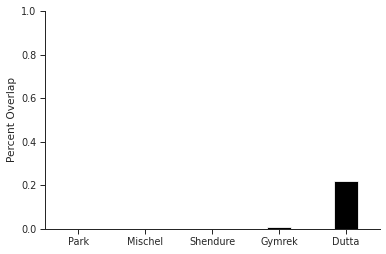

In [119]:
pdf = PdfPages(f'data/plot/2022-10-14-published-catalog-overlap.pdf')

ax = sns.barplot(x='catalog', y='pct', data=data, color='black')
ax.set_xlabel('')
ax.set_ylabel('Percent Overlap')
ax.grid(False)
ax.set_ylim(0, 1)
sns.despine(ax=ax, top=True, right=True)
change_width(ax, .35)
pdf.savefig()

pdf.close()

### (7C) Distance to Nearest cCRE (separated by cCRE type)

In [22]:
rre_distance = pd.read_table("data/output/closest_rre_ccre.bed", header=None)
simple_distance = pd.read_table("data/output/closest_simplerepeats_ccre.bed", header=None)

# Extract distance column from bedtools output
type_col = 8
distance_col = 9
rre_distance = rre_distance[[distance_col, type_col]].rename({distance_col: "distance", type_col: "ccre"}, axis="columns")
simple_distance = simple_distance[[distance_col, type_col]].rename({distance_col: "distance", type_col: "ccre"}, axis="columns")

rre_distance["type"] = "rREs"
simple_distance["type"] = "Simple Repeats"

# Convert distance to kbp
rre_distance["distance"] = rre_distance["distance"] / 10**3
simple_distance["distance"] = simple_distance["distance"] / 10**3

simple_distance = simple_distance[simple_distance["distance"] < 25000]

# Merge the two dataframes
data = pd.concat([rre_distance, simple_distance], ignore_index=True)

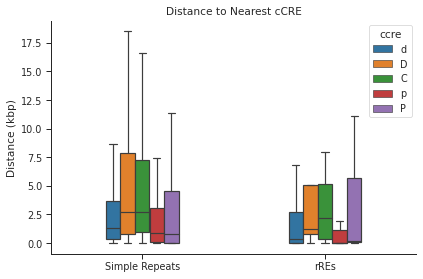

In [23]:
pdf = PdfPages("data/plot/2022-10-17-distance-to-nearest-ccre-by-type.pdf")

fig, ax = plt.subplots()
sns.boxplot(x="type", y="distance", order=["Simple Repeats", "rREs"], hue="ccre", showfliers=False, width=0.4, data=data, ax=ax)
ax.set_title(f"Distance to Nearest cCRE")
ax.set_xlabel("")
ax.set_ylabel("Distance (kbp)")

sns.despine()
# plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
# plt.setp(ax.lines, color='k')
ax.grid(False)
plt.tight_layout()

pdf.savefig(transparent=True)
pdf.close()

### (8B) UGT2B7 Expression

### (8C) UGT2B7 Survival